In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pl

import pandas as pd
import matplotlib.image as mpimg
import glob
import re

import sys
sys.path.append('../')
from functions import *

In [2]:
def curvature(x_path, y_path,scale):
    r, xcs, ycs = [],[],[]
    num_points = len(x_path)

    for i in range(int(scale),int(num_points-scale)):
        x1 = x_path[i-int(scale)]
        y1 = y_path[i-int(scale)]
        x2 = x_path[i]
        y2 = y_path[i]
        x3 = x_path[i+int(scale)]
        y3 = y_path[i+int(scale)]
        
        ma = (y2 - y1)/(x2 - x1)
        mb = (y3 - y2)/(x3 - x2)
        xc = (ma*mb*(y1 - y3) + mb*(x1 + x2) - ma*(x2 + x3))/(2*(mb - ma))
        yc = -1/ma*(xc - (x1 + x2)/2) + (y1 + y2)/2

        if ma == mb:
            rad = float(np.inf)
        else:
            rad = float(np.hypot(xc - x1, yc - y1))

        nv1 = np.cross(np.array([x2 - x1, y2 - y1, 0]), np.array([0 ,0, 1]))
        nv2 = np.cross(np.array([x3 - x2, y3 - y2, 0]), np.array([0 ,0, 1]))
        nv = np.average([nv1, nv2], axis = 0)
        align = -np.sign(np.dot(nv[0:2], np.array([x2 - xc, y2 - yc])))

        if rad == 0:
            r.append(np.nan)
        else:
            r.append(align * 1./rad)
            
        xcs.append(xc)
        ycs.append(yc)

    return r

def alpha_to_rgb(color, alpha):
    """
    Calculates the RGB code of a color with given transparency.
    
    Inputs
    ------
    color : Specified color in HEX representation.
    alpha : Number in the [0,1] interval.
    
    Outputs
    -------
    rgb_new : RGB number triplet of the color with transparency `alpha`.
    """
    rgba = np.array(colors.to_rgba(color))
    rgb_new = alpha*(rgba[0:3]-1)+1
    return rgb_new

In [3]:
save_images = False

In [4]:
df_Rxzero = pd.read_pickle("noforce_Fy_Mp_only.pkl")
df_Ryzero = pd.read_pickle("noforce_Fx_only.pkl")
df = pd.read_pickle("noforce_Fx_Fy_Mp.pkl")
df_Mpzero_Mknonzero = pd.read_pickle("noforce_Fx_Fy_Mk.pkl")
df_Rxzero_Mknonzero = pd.read_pickle("noforce_Fy_Mk_only.pkl")

M0_arr = df["M0 (mcmc)"].values
Rx_arr = df["Rx (mcmc)"].values
PP_K_angle_arr = df["PP-K angle (deg)"].values
L_arr = df["L"].values
PP_dist_arr = df["PP distance"].values


ValueError: unsupported pickle protocol: 5

In [13]:
print("M0:", M0_arr.mean(), M0_arr.std()/np.sqrt(len(M0_arr)))
print("Rx:",Rx_arr.mean(), Rx_arr.std()/np.sqrt(len(Rx_arr)))
print("PPdist:",df["PP distance"].unique().mean(), \
      df["PP distance"].unique().std()/np.sqrt(len(df["PP distance"].unique())))

M0: 0.12045658907364516 0.011367277465590724
Rx: 0.07050817232188711 0.023607582179590476
PPdist: 16.27588930853112 0.7781150108339138


In [14]:
div = L_arr/PP_dist_arr
print(div.min())
print(div.max())
print(PP_dist_arr.mean(),PP_dist_arr.min(),PP_dist_arr.max())
len(df["PP distance"].unique()),len(df["PP distance"])

0.25416692520461953
0.6451423472965789
16.884745159204023 12.401117893157858 28.035


(26, 83)

/var/folders/cp/0lclv8hx2jxbhys0zh6lh07c0000gn/T/ipykernel_3660/838088799.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "_" (-> marker='_'). The keyword argument will take precedence.
  plt.errorbar(angles_avg[i], Mp_means[i], yerr = Mp_sem[i], elinewidth = 3, fmt = '_', \
/var/folders/cp/0lclv8hx2jxbhys0zh6lh07c0000gn/T/ipykernel_3660/838088799.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "_" (-> marker='_'). The keyword argument will take precedence.
  plt.errorbar(angles_avg[i], Mp_means[i], yerr = Mp_sem[i], elinewidth = 3, fmt = '_', \
/var/folders/cp/0lclv8hx2jxbhys0zh6lh07c0000gn/T/ipykernel_3660/838088799.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "_" (-> marker='_'). The keyword argument will take precedence.
  plt.errorbar(angles_avg[i], Mp_means[i], yerr = Mp_sem[i], elinewidth = 3, fmt = '_', \
/var/folde

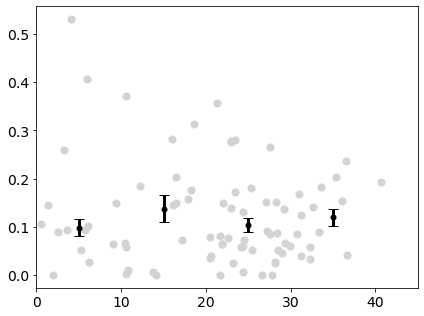

In [15]:
fig = plt.figure(figsize=(6, 4.5))
# angles_low = np.array([0, 15, 25, 35])
# angles_high = np.array([10, 25, 35, 45])
angles_low = np.array([0, 10, 20, 30])
angles_high = np.array([10, 20, 30, 40])
angles_avg = 0.5*(angles_low+angles_high)
n_angles = len(angles_low)

Mp_subsets = []
Mp_means = np.zeros(n_angles)
Mp_std = np.zeros(n_angles)
Mp_sem = np.zeros(n_angles)
for i in range(n_angles):
    Mp_subset = M0_arr[(PP_K_angle_arr >= angles_low[i]) & (PP_K_angle_arr < angles_high[i])]
    L_subset = L_arr[(PP_K_angle_arr >= angles_low[i]) & (PP_K_angle_arr < angles_high[i])]
    if i ==0:
        Mp_subset = np.delete(Mp_subset, 3)
        Mp_subset = np.delete(Mp_subset, 2)
    
    Mp_subsets.append(Mp_subset)
    Mp_means[i] = np.mean(Mp_subset)
    Mp_std[i] = np.std(Mp_subset)
    Mp_sem[i] = np.std(Mp_subset)/np.sqrt(len(Mp_subset))
        
# M0_arr = np.delete(M0_arr, 17)
# M0_arr = np.delete(M0_arr, 15)
# PP_K_angle_arr = np.delete(PP_K_angle_arr, 17)
# PP_K_angle_arr = np.delete(PP_K_angle_arr, 15)

plt.scatter(PP_K_angle_arr, M0_arr, 50, color='lightgray')

for i in range(n_angles):
    plt.errorbar(angles_avg[i], Mp_means[i], yerr = Mp_sem[i], elinewidth = 3, fmt = '_', \
                 color = 'k', marker = '.', markersize = 10, capsize = 5, capthick = 1, zorder = 10)
    
labels = []
for i in range(n_angles):
    labels.append(str(angles_low[i]) + '-' + str(angles_high[i]))

# plt.xlabel(r'rotation angle, $\alpha_{\rm PK}$ [degrees]', fontsize = 14)
# plt.ylabel(r'moment at the pole, $M_p$ [pN$\times$μm]', fontsize = 14)
plt.xticks([0,10,20,30,40], fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,45)
plt.tight_layout()
# if save_images:
plt.savefig('fig_outputs/Mp_vs_rotation_angle.pdf')

/var/folders/cp/0lclv8hx2jxbhys0zh6lh07c0000gn/T/ipykernel_3660/2723527289.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "_" (-> marker='_'). The keyword argument will take precedence.
  plt.errorbar(angles_avg[i], Rx_means[i], yerr = Rx_sem[i], elinewidth = 3, fmt = '_', \
/var/folders/cp/0lclv8hx2jxbhys0zh6lh07c0000gn/T/ipykernel_3660/2723527289.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "_" (-> marker='_'). The keyword argument will take precedence.
  plt.errorbar(angles_avg[i], Rx_means[i], yerr = Rx_sem[i], elinewidth = 3, fmt = '_', \
/var/folders/cp/0lclv8hx2jxbhys0zh6lh07c0000gn/T/ipykernel_3660/2723527289.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "_" (-> marker='_'). The keyword argument will take precedence.
  plt.errorbar(angles_avg[i], Rx_means[i], yerr = Rx_sem[i], elinewidth = 3, fmt = '_', \
/var/fo

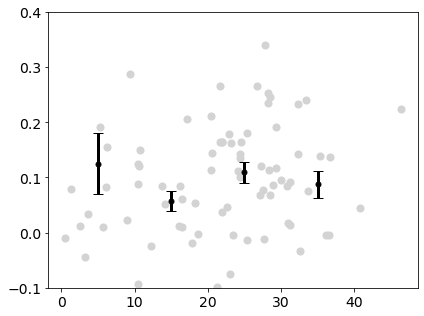

In [16]:
PP_K_angle_arr = df["PP-K angle (deg)"].values
fig = plt.figure(figsize=(6, 4.5))
# angles_low = np.array([0, 15, 25, 35])
# angles_high = np.array([10, 25, 35, 45])
angles_low = np.array([0, 10, 20, 30])
angles_high = np.array([10, 20, 30, 40])
angles_avg = 0.5*(angles_low+angles_high)
n_angles = len(angles_low)

Rx_subsets = []
Rx_means = np.zeros(n_angles)
Rx_std = np.zeros(n_angles)
Rx_sem = np.zeros(n_angles)
for i in range(n_angles):
    Rx_subset = Rx_arr[(PP_K_angle_arr >= angles_low[i]) & (PP_K_angle_arr < angles_high[i])]
    if i ==0:
        Rx_subset = np.delete(Rx_subset, 3)
        Rx_subset = np.delete(Rx_subset, 2)
    Rx_subsets.append(Rx_subset)
    Rx_means[i] = np.mean(Rx_subset)
    Rx_std[i] = np.std(Rx_subset)
    Rx_sem[i] = np.std(Rx_subset)/np.sqrt(len(Rx_subset))

# Rx_arr = np.delete(Rx_arr, 17)
# Rx_arr = np.delete(Rx_arr, 15)
# PP_K_angle_arr = np.delete(PP_K_angle_arr, 17)
# PP_K_angle_arr = np.delete(PP_K_angle_arr, 15)

plt.scatter(PP_K_angle_arr, Rx_arr, 50, color='lightgray')
for i in range(n_angles):
    plt.errorbar(angles_avg[i], Rx_means[i], yerr = Rx_sem[i], elinewidth = 3, fmt = '_', \
                 color = 'k', marker = '.', markersize = 10, capsize = 5, capthick = 1, zorder = 10)
    
labels = []
for i in range(n_angles):
    labels.append(str(angles_low[i]) + '-' + str(angles_high[i]))

# plt.xlabel(r'rotation angle, $\alpha_{\rm PK}$ [degrees]', fontsize = 14)
# plt.ylabel(r'moment at the pole, $M_p$ [pN$\times$μm]', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.1,0.4)
plt.tight_layout()
# if save_images:
plt.savefig('fig_outputs/Rx_vs_rotation_angle.pdf')

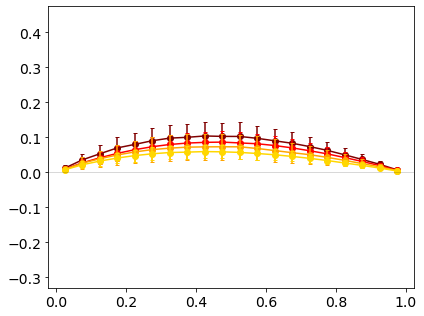

In [19]:
nbins = 20

colors=["gold", "orange", "red", "maroon", "black"]
fig = plt.figure(figsize=(6, 4.5))

for i in range(n_angles):
    
    df_angle = df[(df['PP-K angle (deg)'] >= angles_low[i]) & (df['PP-K angle (deg)'] <= angles_high[i])]
    
    rot_angle = np.mean([angles_low[i], angles_high[i]])
    
    x_mod_ls, y_mod_ls = [], []
    for n, row in df_angle.iterrows():

        x_mod = row["x (mcmc)"]
        y_mod = row["y (mcmc)"]
        L = row["L"]
        
#         x_rot, y_rot = rotate(x_mod, y_mod, np.radians(-rot_angle))
#         x_rot_scale = x_rot/L
#         y_rot_scale = y_rot/L

        x_rot, y_rot = rotate(x_mod, y_mod, np.radians(0))
        x_rot_scale = x_rot/L
        y_rot_scale = y_rot/L
        
        x_mod_ls.append(x_rot_scale)
        y_mod_ls.append(y_rot_scale)
        
        
#         plt.plot(x_rot_scale, y_rot_scale, color=colors[i], ls='--', alpha=0.2)
        
    x, y = [], []
    [x.extend(el) for el in x_mod_ls]
    [y.extend(el) for el in y_mod_ls]
    x = np.array(x)
    y = np.array(y)
    
    n, _ = np.histogram(x, bins=nbins)
    
    sy, _ = np.histogram(x, bins=nbins, weights=y)
    sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)
    plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt = 'o-', capsize=2,color=colors[i],zorder=1-i) #colors[i])
    
plt.axhline(y=0, color="k", lw=0.5, alpha=0.3)
plt.axis("equal")
# plt.xlabel('normalized position \nparallel to the pole-pole axis', fontsize=14)
# plt.ylabel('normalized position \nnormal to the pole-pole axis', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_images:
    plt.savefig('fig_outputs/average_profiles_collapsed.pdf')

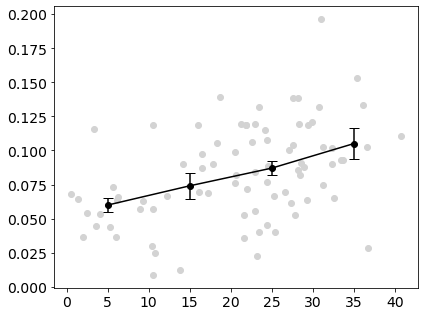

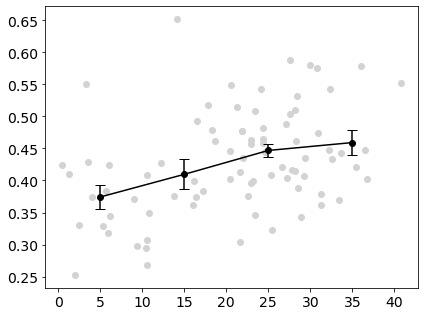

In [20]:
angles_low = np.array([0, 10, 20, 30])
angles_high = np.array([10, 20, 30, 45])
angles_avg = 0.5*(angles_low+angles_high)
n_angles = len(angles_low)

nbins = 20

colors=["gold", "orange", "red", "maroon", "black"]
maxy,angles = [],[]
L_ls,PPdist_ls,Lc_ls, ratio_ls = [],[],[],[]
Lc_mean, ymax_mean,ratio_mean,ratio_sem = [],[],[],[]
for i in range(n_angles):
    
    df_angle = df[(df['PP-K angle (deg)'] >= angles_low[i]) & (df['PP-K angle (deg)'] <= angles_high[i])]
    
    rot_angle = np.mean([angles_low[i], angles_high[i]])
#     print(rot_angle,df_angle["L"].mean(),df_angle["L"].median())
    
    x_mod_ls, y_mod_ls = [], []
    Lc_temp,maxy_temp,ratio_temp = [],[],[]
    for n, row in df_angle.iterrows():

        x_mod = row["x (mcmc)"]
        y_mod = row["y (mcmc)"]
        s,L_contour = contour_fn(x_mod,y_mod)
        L = row["L"]
        PP_dist = row["PP distance"]
        M0 = row["M0 (mcmc)"]
        Rx = row["Rx (mcmc)"]
        angle = row["PP-K angle (deg)"]
        ratio = L_contour/PP_dist
        x_rot, y_rot = rotate(x_mod, y_mod, np.radians(0))
        x_rot_scale = x_rot/L
        y_rot_scale = y_rot/L
        r = curvature(x_rot_scale,y_rot_scale,10)
        if ratio == 0.5506617009932508 and angle == 3.270438936347056:
            continue
#         print(L_contour/PP_dist,angle)
        angles.append(angle)
        maxy.append(max(y_rot_scale))
        L_ls.append(L)
        Lc_ls.append(L_contour)
        PPdist_ls.append(PP_dist)
        x_mod_ls.append(x_rot_scale)
        y_mod_ls.append(y_rot_scale)
        peak_val = np.max(y_rot_scale)
        peak_loc = x_rot_scale[y_rot_scale ==y_rot_scale.max()]
        Lc_temp.append(L_contour)
        ratio_ls.append(ratio)
        ratio_temp.append(L_contour/PP_dist)
        maxy_temp.append(max(y_rot_scale))
    Lc_mean.append(np.mean(Lc_temp))
    ymax_mean.append(np.mean(maxy_temp))
    ratio_mean.append(np.mean(ratio_temp))
    ratio_sem.append(np.std(ratio_temp)/np.sqrt(len(ratio_temp)))

angles = np.array(angles)
ratio = np.array(ratio)
maxy = np.array(maxy)
Lc_ls = np.array(Lc_ls) 
L_ls = np.array(L_ls)
PPdist_ls = np.array(PPdist_ls)
    
fig = plt.figure(figsize=(6, 4.5))
x = angles
y = maxy
plt.scatter(x, y, color='lightgray')

nbins = np.array([0,10,20,30,40])
n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std/np.sqrt(n), fmt='o-',color='k',capsize=5,zorder=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("fig_outputs/maxy_vs_kfibangle.pdf")
    
plt.show()

fig = plt.figure(figsize=(6, 4.5))
x = angles
y = Lc_ls/PPdist_ls
# x = np.delete(x, 17)
# y = np.delete(y, 15)

plt.scatter(x, y, color='lightgray')

nbins = np.array([0,10,20,30,45])
n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.errorbar([5,15,25,35], mean, yerr=std/np.sqrt(n), fmt='o-',color='k',capsize=5,zorder=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("fig_outputs/length_vs_kfibangle.pdf")
plt.show()



In [21]:
print("Lc/PP mean:", ratio_mean)
print("Lc/PP sem:", ratio_sem)


Lc/PP mean: [0.37418483467824054, 0.4095665655612051, 0.44683338657888166, 0.45911862667146547]
Lc/PP sem: [0.018787386821119658, 0.023171745004772627, 0.01074419578046872, 0.019361728240386393]


/var/folders/cp/0lclv8hx2jxbhys0zh6lh07c0000gn/T/ipykernel_3660/68828340.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "_" (-> marker='_'). The keyword argument will take precedence.
  plt.errorbar([0,1],[np.mean(var1),np.mean(var2)],\


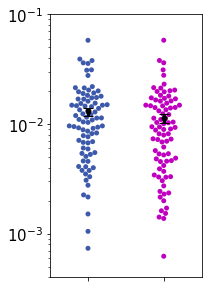

mann-whitney U test
0.1571908237770554


In [52]:
df_MkMpnonzero = pd.read_pickle("noforce_unconstrained.pkl")
df = pd.read_pickle("noforce_Fx_Fy_Mp.pkl")

RMSE_Mkzero_ls = df["RMSE (mcmc)"].values
RMSE_MkMpnonzero_ls = df_MkMpnonzero["RMSE (mcmc)"].values

plt.figure(figsize=(3,4))
seed = 4
np.random.seed(seed)

var1 = RMSE_Mkzero_ls
var2 = RMSE_MkMpnonzero_ls

plt.yscale("log")

sns.swarmplot(data=[var1,var2], palette = ["#3D59AB","m"], size = 5)
plt.errorbar([0,1],[np.mean(var1),np.mean(var2)],\
             yerr = [np.std(var1)/np.sqrt(len(var1)),np.std(var2)/np.sqrt(len(var2))],\
             elinewidth = 3, fmt = '_', color = 'k', marker = '.', markersize = 10, \
             capsize = 5, capthick = 1, zorder = 10)

plt.xticks([0,1], ("",""),fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.ylim(0.0004,0.1)
# plt.gca().invert_yaxis()

if save_images:
    plt.savefig('fig_outputs/MkMpnonzero_RMSE.pdf')
plt.show()

from scipy.stats import mannwhitneyu
print("mann-whitney U test")
print(mannwhitneyu(RMSE_Mkzero_ls, RMSE_MkMpnonzero_ls, alternative='two-sided')[1])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


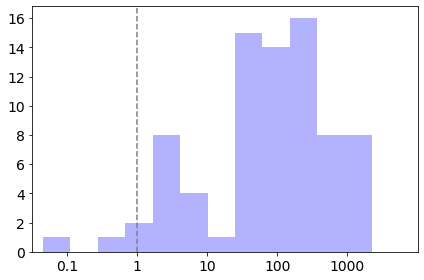

In [29]:
Rx = df_MkMpnonzero["Rx (mcmc)"].mean()
Ry = df_MkMpnonzero["Ry (mcmc)"].mean()
M0 = df_MkMpnonzero["M0 (mcmc)"].mean()

Mk_ls = []
for index, row in df_MkMpnonzero.iterrows():
    Mk_ls.append(row["M0 (mcmc)"] - (row["Ry (mcmc)"]*row["L"]))
Mk = np.mean(Mk_ls)

plt.hist(np.log10(df_MkMpnonzero["M0 (mcmc)"].values/np.array(Mk_ls)),bins=20,color='b',alpha=0.3);
plt.xticks([-1,0,1,2,3], [0.1,1,10,100,1000],fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(0,color='grey',ls='--')
plt.xlim(-1.5,4)
plt.tight_layout()
if save_images:
    plt.savefig("fig_outputs/M0Mkratio.pdf")
plt.show()

### Small angle tests

/var/folders/cp/0lclv8hx2jxbhys0zh6lh07c0000gn/T/ipykernel_3660/2137247500.py:32: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.scatter(x2[i],var2[i],color='#3D59AB',edgecolor='k',lw=0.5,s=100, alpha=w_M0[i]/Z[i],zorder=10)


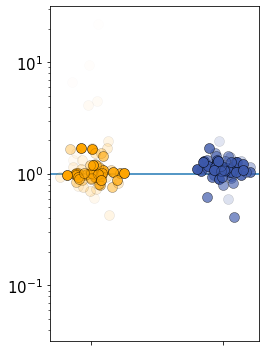

In [3]:
df = pd.read_pickle("noforce_Fx_Fy_Mp.pkl")

Rx_SA = df["Rx (small angle)"].values
M0_SA = df["M0 (small angle)"].values
Ry_SA = df["Ry (small angle)"].values

Rx_exact = df["Rx (mcmc)"].values
M0_exact = df["M0 (mcmc)"].values
Ry_exact = df["Ry (mcmc)"].values

L = df["L"].values
y = df["y (mcmc)"].values
y_max = np.array([np.max(elem) for elem in y])

w_Rx = np.abs(Rx_exact*y_max)
w_M0 = np.abs(M0_exact)
Z = (w_Rx + w_M0)

plt.figure(figsize=(3.8,5))

var1 = Rx_SA/Rx_exact
var2 = M0_SA/M0_exact

seed = 4
np.random.seed(seed)
x1 = np.random.normal(0.5,0.1,len(var1))
x2 = np.random.normal(1.5,0.1,len(var2))

plt.yscale("log")
for i in range(len(var1)):
    plt.scatter(x1[i],var1[i],color="orange",edgecolor='k',lw=0.5, s=100, alpha=w_Rx[i]/Z[i],zorder=10)
    plt.scatter(x2[i],var2[i],color='#3D59AB',edgecolor='k',lw=0.5,s=100, alpha=w_M0[i]/Z[i],zorder=10)

plt.yticks([1e-1, 1e0, 1e1])
plt.ylim([10**-1.5, 10**1.5])

plt.xticks([0.5,1.5], ("",""),fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.axhline(1)


plt.savefig('fig_outputs/small_vs_exact_ratios.pdf')
plt.show()

/var/folders/cp/0lclv8hx2jxbhys0zh6lh07c0000gn/T/ipykernel_3660/3847608540.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "_" (-> marker='_'). The keyword argument will take precedence.
  plt.errorbar([0,1],[np.mean(var1),np.mean(var2)],\


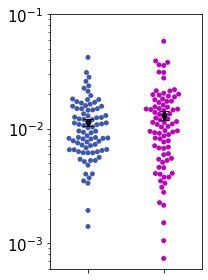

In [4]:
err_SA = df["RMSE (small angle)"].values
err_exact = df["RMSE (mcmc)"].values
diff_model_err = np.abs(err_SA - err_exact)/err_exact

plt.figure(figsize=(3,4))

var1 = err_SA
var2 = err_exact
plt.yscale("log")

sns.swarmplot(data=[var1,var2], palette = ["#3D59AB","m"], size = 5)
plt.errorbar([0,1],[np.mean(var1),np.mean(var2)],\
             yerr = [np.std(var1)/np.sqrt(len(var1)),np.std(var2)/np.sqrt(len(var2))],\
             elinewidth = 3, fmt = '_', color = 'k', marker = '.', markersize = 10, \
             capsize = 5, capthick = 1, zorder = 10)

plt.xticks([0,1], ("",""),fontsize=15)
plt.yticks([1e-3, 1e-2, 1e-1], fontsize=15)

plt.tight_layout()

plt.savefig('fig_outputs/smallangle_approx_errors.pdf')
plt.show()

In [93]:
df = pd.read_pickle("/Users/poojasuresh/Google Drive/Modeling the spindle mechanics (1)/_paper/src/fig2/noforce_Fx_Fy_Mp.pkl")
df_junction = pd.read_pickle("noforce_junction.pkl")

20180622_cell015 0 -0.23366487938382074
20180622_cell026 0 -0.39025877425917344
20180628_cell010 2 -0.07644057289578754
20180628_cell013 4 -0.002292420054320843


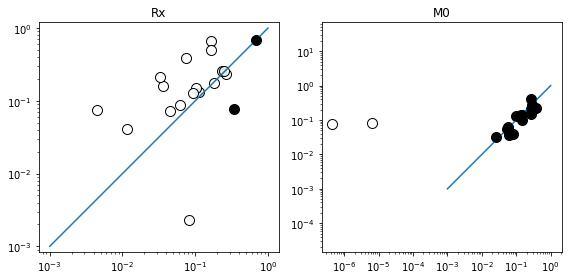

In [94]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
RMSE,RMSE_j = [],[]
for index, row_j in df_junction.iterrows():
    spindle = row_j["Spindle"]
    kfiber = row_j["Kfiber"]
    
    row = df.loc[(df['Spindle'] == spindle) & (df['Kfiber'] == kfiber)]

    #calculating weights
    L = row["L"].values
    y = row["y (mcmc)"].values
    y_max = max(y)[0]
    w_Rx = np.abs(row["Rx (mcmc)"].values[0]*y_max)
    w_M0 = np.abs(row["M0 (mcmc)"].values[0])
    Z = (w_Rx + w_M0)

    RMSE.append(row["RMSE (mcmc)"].values[0])
    RMSE_j.append(row_j["RMSE (mcmc)"])
    ax[0].set_title("Rx")
    ax[1].set_title("M0")
    ax[0].scatter(np.abs(row["Rx (mcmc)"]),np.abs(row_j["Rx (mcmc)"]),c='w',s=100,alpha=1,edgecolor='k')
    ax[0].scatter(np.abs(row["Rx (mcmc)"]),np.abs(row_j["Rx (mcmc)"]),c='k',s=80,alpha=w_Rx/Z,zorder=10)
    ax[1].scatter(np.abs(row["M0 (mcmc)"]),np.abs(row_j["M0 (mcmc)"]),c='w',s=100, alpha=1,edgecolor='k')
    ax[1].scatter(np.abs(row["M0 (mcmc)"]),np.abs(row_j["M0 (mcmc)"]),c='k',s=80, alpha=w_M0/Z,zorder=10)
    if row_j["Rx (mcmc)"]<0.001:
        print(spindle,kfiber,row_j["Rx (mcmc)"])
for i in range(2):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].plot([0.001,1],[0.001,1])
    ax[i].axis("equal")
# plt.xlabel("df")
# plt.ylabel("df_j")
plt.tight_layout()

plt.show()


L = df["L"].values
y = df["y (mcmc)"].values
y_max = np.array([np.max(elem) for elem in y])



In [58]:
w_Rx

array([0.10120702])

In [44]:
row_j["RMSE (mcmc)"]

0.010493546005453096

<ErrorbarContainer object of 3 artists>

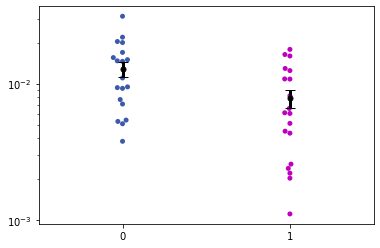

In [92]:
plt.yscale("log")
var1 = np.array(RMSE)
var2 = np.array(RMSE_j)
sns.swarmplot(data=[var1,var2], palette = ["#3D59AB","m"], size = 5)
plt.errorbar([0,1],[np.mean(var1),np.mean(var2)],\
             yerr = [np.std(var1)/np.sqrt(len(var1)),np.std(var2)/np.sqrt(len(var2))],\
             elinewidth = 3, fmt = '_', color = 'k', marker = '.', markersize = 10, \
             capsize = 5, capthick = 1, zorder = 10)


In [63]:
for index, row_j in df_junction.iterrows():
    spindle = row_j["Spindle"]
    kfiber = row_j["Kfiber"]
    print(spindle)

20180612_cell001
20180620_cell013
20180620_cell013
20180622_cell015
20180622_cell020
20180622_cell026
20180622_cell027
20180622_cell028
20180626_cell001
20180628_cell006
20180628_cell010
20180628_cell010
20180628_cell013
20180628_cell013
20180810_cell005
20180810_cell006
20210526_cell001


In [ ]:
## 